### 2D and 3D phase space reconstructions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import multiprocessing
import os
import zipfile
from minepy import MINE

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_2d_dir = os.path.join(base_dir, '2dembedding_data')
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
plots_directory = os.path.join(base_dir, 'plots')

# Ensure directories exist
for dir_path in [embedding_2d_dir, embedding_3d_dir, plots_directory]:
    os.makedirs(dir_path, exist_ok=True)

# Load EEG data
EEG_data = np.load(os.path.join(base_dir, 'eeg_data_with_channels.npy'), allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515 # Data without stimulation occuring
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
filtered_EEG_data = EEG_data[start_index:end_index, :]

max_dim = 20

def mutual_info_worker(args):
    data1, data2 = args
    mine = MINE(alpha=0.6, c=15)
    mine.compute_score(data1, data2)
    return mine.mic()

def determine_delay(data, max_delay=100, subsample_factor=10):
    subsampled_data = data[::subsample_factor]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        mi_values = pool.map(mutual_info_worker, [(subsampled_data[:-i], subsampled_data[i:]) for i in range(1, max_delay + 1)])
    return np.argmin(mi_values) + 1

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i + emb_dim * delay:delay] for i in range(N - (emb_dim - 1) * delay)])

def false_nearest_neighbors(data, emb_dim, delay, R=10):
    N = len(data)
    false_neighbors = np.zeros(emb_dim)
    for d in range(1, emb_dim + 1):
        emb_data = delay_embedding(data, d, delay)
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_data)
        distances, indices = nbrs.kneighbors(emb_data)
        false_neighbors[d - 1] = np.mean((np.abs(distances[:, 0] - distances[:, 1]) / distances[:, 1]) > R)
    return false_neighbors

# Analyze each EEG channel
for channel_name in eeg_channel_names:
    channel_index = eeg_channel_names.index(channel_name)
    channel_data = filtered_EEG_data[:, channel_index]

    optimal_delay = determine_delay(channel_data, max_delay=20, subsample_factor=10)
    emb_dim_2d, emb_dim_3d = 2, 3

    embedded_data_2d = delay_embedding(channel_data, emb_dim_2d, optimal_delay)
    embedded_data_3d = delay_embedding(channel_data, emb_dim_3d, optimal_delay)

    np.save(os.path.join(embedding_2d_dir, f'2dembedded_{channel_name}.npy'), embedded_data_2d)
    np.save(os.path.join(embedding_3d_dir, f'3dembedded_{channel_name}.npy'), embedded_data_3d)

    # Generate and save plots
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data_2d[:, 0], embedded_data_2d[:, 1], s=1)
    plt.title(f'2D Phase Space Reconstruction for {channel_name}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig(os.path.join(plots_directory, f'2D_{channel_name}.png'))
    plt.close()

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embedded_data_3d[:, 0], embedded_data_3d[:, 1], embedded_data_3d[:, 2], s=1)
    ax.set_title(f'3D Phase Space Reconstruction for {channel_name}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.savefig(os.path.join(plots_directory, f'3D_{channel_name}.png'))
    plt.close()

# Zip the embedded data directories
for dir_path, zip_name in [(embedding_2d_dir, '2d_embedded_data.zip'), (embedding_3d_dir, '3d_embedded_data.zip')]:
    with zipfile.ZipFile(os.path.join(base_dir, zip_name), 'w') as zipf:
        for file in os.listdir(dir_path):
            zipf.write(os.path.join(dir_path, file), file)

print("All processes completed successfully.")

#### Elbows for getting an idea for parameters

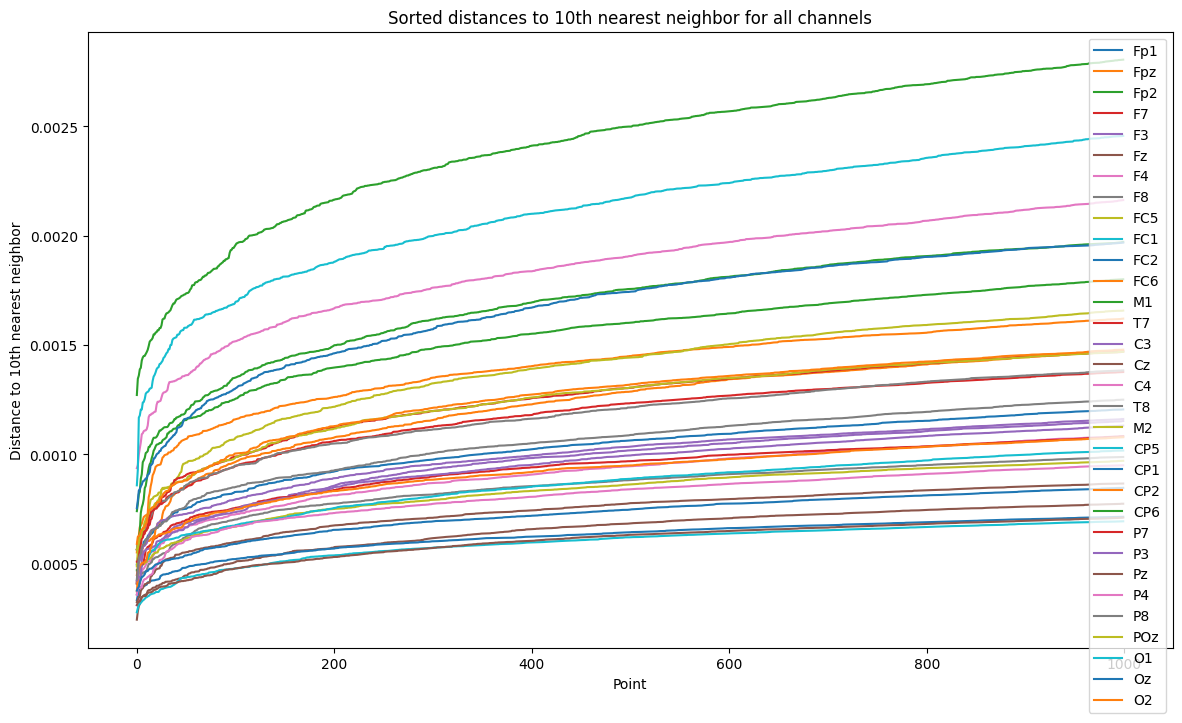

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import os

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'

# Load EEG data
EEG_data = np.load(os.path.join(base_dir, 'eeg_data_with_channels.npy'), allow_pickle=True)

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515 # Data without stimulation occuring
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
filtered_EEG_data = EEG_data[start_index:end_index, :]

import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Define the min_samples value you plan to use with UMAP
min_samples = 10

# Load EEG data (the following is an example path, replace with the actual path to your EEG data)
EEG_data = filtered_EEG_data

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Create a figure for plotting
plt.figure(figsize=(14, 8))

# Loop through all channels and plot the elbow plot for each
for channel_index, channel_name in enumerate(eeg_channel_names):
    # Select the data for the current channel
    channel_data = EEG_data[:, channel_index].reshape(-1, 1)  # Reshape for NearestNeighbors
    
    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(channel_data)
    distances, indices = neighbors.kneighbors(channel_data)

    # Sort the distances
    distances = np.sort(distances[:, min_samples-1], axis=0)

    # Plotting the elbow plot for the first 1000 points of the current channel
    plt.plot(distances[:1000], label=channel_name)

plt.xlabel('Point')
plt.ylabel('Distance to 10th nearest neighbor')
plt.title('Sorted distances to 10th nearest neighbor for all channels')
plt.legend(loc='upper right')  # Adjust the legend location so it doesn't overlap the lines
plt.show()

### UMAP and t-SNE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
plots_dir = os.path.join(base_dir, 'plots')
embeddings_dir = os.path.join(base_dir, 'embeddings')

# Create directories for plots and embeddings if they don't exist
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(embeddings_dir, exist_ok=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Define the UMAP and t-SNE parameters
n_components_umap = 2
n_neighbors_umap = 15
min_dist_umap = 0.1
random_state_umap = 42

n_components_tsne = 2
perplexity_tsne = 30
random_state_tsne = 42

# Function to apply UMAP
def apply_umap(data, n_components, n_neighbors, min_dist, random_state):
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    embedding = reducer.fit_transform(data)
    return embedding

# Function to apply t-SNE
def apply_tsne(data, n_components, perplexity, random_state):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        random_state=random_state
    )
    embedding = tsne.fit_transform(data)
    return embedding

# Loop through each channel's 3D embedded data
for channel_name in eeg_channel_names:
    data_path = os.path.join(embedding_3d_dir, f'3dembedded_{channel_name}.npy')
    channel_data_3d = np.load(data_path)
    
    # Apply UMAP and t-SNE to each channel's 3D embedded data
    umap_embedding = apply_umap(channel_data_3d, n_components_umap, n_neighbors_umap, min_dist_umap, random_state_umap)
    tsne_embedding = apply_tsne(channel_data_3d, n_components_tsne, perplexity_tsne, random_state_tsne)
    
    # Save the embeddings to .npy files
    np.save(os.path.join(embeddings_dir, f'umap_embedding_{channel_name}.npy'), umap_embedding)
    np.save(os.path.join(embeddings_dir, f'tsne_embedding_{channel_name}.npy'), tsne_embedding)
    
    # Create and save UMAP plot
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=5)
    plt.title(f'UMAP for {channel_name}')
    plt.savefig(os.path.join(plots_dir, f'UMAP_{channel_name}.png'))
    plt.close()  # Close the figure to free up memory
    
    # Create and save t-SNE plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=5)
    plt.title(f't-SNE for {channel_name}')
    plt.savefig(os.path.join(plots_dir, f'tSNE_{channel_name}.png'))
    plt.close()  # Close the figure to free up memory

/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/vincent/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed f

### Sample Entropy, Box Counting Dimension, 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import hdbscan
from scipy.spatial import cKDTree
import nolds
import pandas as pd

# Define the base directory for the UMAP embeddings
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_dir = os.path.join(base_dir, 'embeddings')

# EEG channel names corresponding to the UMAP embeddings
eeg_channel_names = ['C3', 'C4', 'CP1', 'CP2', 'CP5', 'CP6', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FC1', 'FC2', 'FC5', 'FC6', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'M1', 'M2', 'O1', 'O2', 'Oz', 'P3', 'P4', 'P7', 'P8', 'POz', 'Pz', 'T7', 'T8']

def sample_entropy_nolds(u, m=2, r=None):
    if r is None:
        r = 0.2 * np.std(u)
    return nolds.sampen(u, emb_dim=m, tolerance=r)

def correlation_dimension_nolds(data, emb_dim=10):
    # Flatten the data to make it a 1D time series
    data_flattened = data.flatten()
    # Calculate the correlation dimension
    corr_dim = nolds.corr_dim(data_flattened, emb_dim)
    return corr_dim

# Collect results
results = []

def analyze_channel_data_hdbscan(channel_data_2d, channel_name):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
    clusters = clusterer.fit_predict(channel_data_2d)
    
    sample_entropy_value = sample_entropy_nolds(channel_data_2d.flatten())
    
    corr_dim = correlation_dimension_nolds(channel_data_2d)

    
    results.append({
        "Channel": channel_name,
        "Number of Clusters": len(set(clusters)) - (1 if -1 in clusters else 0),
        "Sample Entropy": sample_entropy_value,
        "Correlation Dimension": corr_dim
    })

# Loop over each EEG channel's UMAP embedding
for channel_name in eeg_channel_names:
    data_path = os.path.join(embedding_dir, f'umap_embedding_{channel_name}.npy')
    channel_data_2d = np.load(data_path)
    
    analyze_channel_data_hdbscan(channel_data_2d, channel_name)

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(results)
csv_path = os.path.join(base_dir, 'analysis_results_umap.csv')
results_df.to_csv(csv_path, index=False)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].bar(results_df['Channel'], results_df['Number of Clusters'])
axs[0].set_title('Number of Clusters per Channel')
axs[0].tick_params(axis='x', rotation=90)
axs[1].bar(results_df['Channel'], results_df['Sample Entropy'])
axs[1].set_title('Sample Entropy per Channel')
axs[1].tick_params(axis='x', rotation=90)
axs[2].bar(results_df['Channel'], results_df['Correlation Dimension'])
axs[2].set_title('Correlation Dimension per Channel')
axs[2].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

### Phase space reconstruction using caos method

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import multiprocessing
import os
import zipfile
from minepy import MINE

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_2d_dir = os.path.join(base_dir, '2dembedding_data')
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
plots_directory = os.path.join(base_dir, 'plots')

# Load EEG data
EEG_data = np.load(os.path.join(base_dir, 'eeg_data_with_channels.npy'), allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

sampling_rate = 1000  # Hz
start_time, end_time = 805.571, 921.515
start_index, end_index = int(start_time * sampling_rate), int(end_time * sampling_rate)
filtered_EEG_data = EEG_data[start_index:end_index, :]

max_dim = 20

def mutual_info_worker(args):
    data1, data2 = args
    mine = MINE(alpha=0.6, c=15)
    mine.compute_score(data1, data2)
    return mine.mic()

def determine_delay(data, max_delay=100, subsample_factor=10):
    subsampled_data = data[::subsample_factor]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        mi_values = pool.map(mutual_info_worker, [(subsampled_data[:-i], subsampled_data[i:]) for i in range(1, max_delay + 1)])
    return np.argmin(mi_values) + 1

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i + emb_dim * delay:delay] for i in range(N - (emb_dim - 1) * delay)])

def false_nearest_neighbors(data, emb_dim, delay, R=10):
    N = len(data)
    false_neighbors = np.zeros(emb_dim)
    for d in range(1, emb_dim + 1):
        emb_data = delay_embedding(data, d, delay)
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_data)
        distances, indices = nbrs.kneighbors(emb_data)
        false_neighbors[d - 1] = np.mean((np.abs(distances[:, 0] - distances[:, 1]) / distances[:, 1]) > R)
    return false_neighbors
    
def caos_method(data, max_dim=20, tau=1):
    def nearest_distance(embedded_data):
        """Compute the nearest distance for each point in the embedded data."""
        min_distances = np.full(len(embedded_data), np.inf)
        for i in range(len(embedded_data)):
            for j in range(len(embedded_data)):
                if i != j:
                    dist = np.sum((embedded_data[i] - embedded_data[j]) ** 2)
                    min_distances[i] = min(min_distances[i], dist)
        return np.sqrt(min_distances)

    def embedding(data, dim, tau):
        """Embeds data according to given dimension and time delay."""
        N = len(data)
        if N - (dim - 1) * tau < 1:
            return None
        embedded_data = np.array([data[i:N - (dim - 1) * tau + i:tau] for i in range(dim)]).T
        return embedded_data

    E1 = np.zeros(max_dim)
    E2 = np.zeros(max_dim - 1)

    for dim in range(1, max_dim + 1):
        embedded_data = embedding(data, dim, tau)
        if embedded_data is None:
            break

        min_distances = nearest_distance(embedded_data)
        if dim < max_dim:
            embedded_data_next = embedding(data, dim + 1, tau)
            min_distances_next = nearest_distance(embedded_data_next)
            E1[dim - 1] = np.mean(min_distances_next / min_distances[:-1])
            if dim > 1:
                E2[dim - 2] = E1[dim - 1] / E1[dim - 2]

    return E1, E2
    
# Analyze each EEG channel using Cao's method and generate plots
for channel_name in eeg_channel_names:
    channel_index = eeg_channel_names.index(channel_name)
    channel_data = filtered_EEG_data[:, channel_index]

    # Assuming optimal_delay is predefined or determined by another method
    optimal_delay = determine_delay(channel_data, max_delay=20, subsample_factor=10)

    # Determine the optimal embedding dimension using Cao's method
    E1, E2 = caos_method(channel_data, max_dim=20, tau=optimal_delay)
    optimal_dim = np.argmax(E2 < 1.05) + 2  # Adjust this criterion based on your analysis

    # Perform embedding with the determined optimal dimension
    embedded_data = delay_embedding(channel_data, emb_dim=optimal_dim, delay=optimal_delay)

    # Save the embedded data
    if optimal_dim == 2:
        np.save(os.path.join(embedding_2d_dir, f'2dembedded_{channel_name}.npy'), embedded_data)
    else:
        np.save(os.path.join(embedding_3d_dir, f'3dembedded_{channel_name}.npy'), embedded_data)

    # Generate and save plot for the optimal embedding
    if emb_dim == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(embedded_data[:, 0], embedded_data[:, 1], s=1)
        plt.title(f'2D Phase Space Reconstruction for {channel_name}')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.savefig(os.path.join(plots_directory, f'2D_{channel_name}.png'))
        plt.close()
    elif emb_dim == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], s=1)
        ax.set_title(f'3D Phase Space Reconstruction for {channel_name}')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        plt.savefig(os.path.join(plots_directory, f'3D_{channel_name}.png'))
        plt.close()

# Zip the embedded data directories
for dir_path, zip_name in [(embedding_2d_dir, '2d_embedded_data_caos.zip'), (embedding_3d_dir, '3d_embedded_data_caos.zip')]:
    with zipfile.ZipFile(os.path.join(base_dir, zip_name), 'w') as zipf:
        for file in os.listdir(dir_path):
            zipf.write(os.path.join(dir_path, file), file)

print("All processes completed successfully.")

### Topological data analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gudhi as gd
from umap import UMAP

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')
persistence_dir = os.path.join(base_dir, 'persistence_diagrams')
betti_plot_dir = os.path.join(base_dir, 'betti_plots')

# Create directories for persistence diagrams and Betti number plots if they don't exist
os.makedirs(persistence_dir, exist_ok=True)
os.makedirs(betti_plot_dir, exist_ok=True)

# List all .npy files in the directory
embedding_files = [file for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Define the UMAP parameters
n_components_umap = 2
random_state_umap = 42

def compute_persistence_diagrams(data):
    """
    Compute the persistence diagrams for a given dataset using Vietoris-Rips complex.
    :param data: Input dataset, assumed to be the output of a dimensionality reduction method.
    :return: Persistence diagrams for the dataset.
    """
    rips_complex = gd.RipsComplex(points=data, max_edge_length=2)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()
    return persistence

def plot_persistence_diagrams(persistence):
    """
    Plot the persistence diagrams.
    :param persistence: Persistence diagrams.
    """
    gd.plot_persistence_diagram(persistence)
    plt.show()

def calculate_betti_numbers(persistence):
    """
    Calculate Betti numbers from the persistence diagrams.
    :param persistence: Persistence diagrams.
    :return: Betti numbers (b0, b1, b2) counting the number of connected components, loops, and voids respectively.
    """
    betti_numbers = {i: 0 for i in range(3)}  # Assuming we're only interested in dimensions 0, 1, and 2
    for interval in persistence:
        if interval[0] < 3:  # Filter out infinite persistence intervals
            betti_numbers[interval[0]] += 1
    return betti_numbers[0], betti_numbers[1], betti_numbers[2]

def plot_betti_numbers(betti_numbers, channel_name):
    plt.bar(range(len(betti_numbers)), list(betti_numbers.values()), tick_label=list(betti_numbers.keys()))
    plt.title(f'Betti Numbers for {channel_name}')
    plt.ylabel('Betti Number')
    plt.xlabel('Dimension')
    plt.savefig(os.path.join(betti_plot_dir, f'Betti_{channel_name}.png'))
    plt.close()

# Define segment length for synthetic labels
segment_length = 1000  # Define this based on your specific needs

# Loop through each .npy file and perform analysis
for file in embedding_files:
    file_path = os.path.join(data_dir, file)
    channel_data_3d = np.load(file_path)
    
    # Perform UMAP dimensionality reduction
    umap_reducer = UMAP(n_components=2, random_state=42)
    reduced_data_umap = umap_reducer.fit_transform(channel_data_3d)

    # Synthetic labels for demonstration (alternating every `segment_length` samples)
    num_segments = reduced_data_umap.shape[0] // segment_length
    labels = np.array([i % 2 for i in range(num_segments) for _ in range(segment_length)])
    labels = np.pad(labels, (0, reduced_data_umap.shape[0] - len(labels)), 'edge')  # Pad labels if necessary

    # Ensure the length of `labels` matches the number of rows in `reduced_data_umap`
    assert len(labels) == reduced_data_umap.shape[0]

    # Compute Persistence Diagrams
    persistence = compute_persistence_diagrams(reduced_data_umap)
    
    # Save Persistence Diagrams
    np.save(os.path.join(persistence_dir, f'persistence_{channel_name}.npy'), np.array(persistence))

    # Plot Persistence Diagrams
    plot_persistence_diagrams(persistence)

    # Calculate Betti Numbers
    betti_numbers = calculate_betti_numbers(persistence)
    print(f"Betti Numbers for {file}:", betti_numbers)

    # Plot and save Betti Numbers
    plot_betti_numbers(betti_numbers, channel_name)

    # Assuming `reduced_data_umap` is now your features for machine learning
    X = reduced_data_umap
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(reduced_data_umap, labels, test_size=0.3, random_state=42)

    # Initialize and train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy for {file}: {accuracy:.2f}")

### Lyapunov Exponents


In [5]:
import os
import nolds
import numpy as np

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Calculate the Lyapunov exponent for each file
for file_path in file_paths:
    # Load the embedding data from the file
    data = np.load(file_path)
    
    # Ensure data is in a compatible shape (one-dimensional, for example)
    if data.ndim > 1:
        # Example approach: flattening or selecting a single dimension
        # data = data.flatten()  # If flattening is appropriate
        data = data[:, 0]  # If selecting the first dimension is appropriate
    
    # Calculate the Lyapunov exponent with adjusted parameters
    try:
        lyap_exp = nolds.lyap_e(data, emb_dim=7, matrix_dim=3)
        print(f"Lyapunov Exponent for {os.path.basename(file_path)}: {lyap_exp}")
    except ValueError as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")

Lyapunov Exponent for 3dembedded_CP2.npy: [ 0.1001663  -0.0219188  -0.21810247]
Lyapunov Exponent for 3dembedded_Fp1.npy: [ 0.19647275  0.02226023 -0.20337339]
Lyapunov Exponent for 3dembedded_O2.npy: [ 0.19795118  0.02735571 -0.2032668 ]
Lyapunov Exponent for 3dembedded_Fpz.npy: [ 0.15226585  0.00386987 -0.21039629]
Lyapunov Exponent for 3dembedded_FC1.npy: [ 0.12120797 -0.00965013 -0.21473414]
Lyapunov Exponent for 3dembedded_T8.npy: [ 0.17768966  0.0163281  -0.20549665]
Lyapunov Exponent for 3dembedded_FC6.npy: [ 0.13305233 -0.0055372  -0.21391827]
Lyapunov Exponent for 3dembedded_POz.npy: [ 0.12713753 -0.00908613 -0.21416833]
Lyapunov Exponent for 3dembedded_Fp2.npy: [ 0.15001811  0.00124385 -0.21222056]
Lyapunov Exponent for 3dembedded_P3.npy: [ 0.13931774 -0.00197571 -0.21262725]
Lyapunov Exponent for 3dembedded_CP6.npy: [ 0.17250739  0.01311552 -0.21110822]
Lyapunov Exponent for 3dembedded_FC2.npy: [ 0.13367797 -0.0054545  -0.21452849]
Lyapunov Exponent for 3dembedded_P8.npy: [ 

##### Lyapunov Exponents v.2

In [ ]:
import os
import nolds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a list to collect Lyapunov exponent results
lyap_results = []

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Calculate the Lyapunov exponent for each file
for file_path in file_paths:
    # Load the embedding data from the file
    data = np.load(file_path)
    
    # Ensure data is in a compatible shape (one-dimensional, for example)
    if data.ndim > 1:
        data = data[:, 0]  # Selecting the first dimension
        
    # Calculate the Lyapunov exponent with adjusted parameters
    try:
        lyap_exp = nolds.lyap_e(data, emb_dim=7, matrix_dim=3)
        # Store the results along with the file name
        lyap_results.append({'File': os.path.basename(file_path), 'Dim1': lyap_exp[0], 'Dim2': lyap_exp[1], 'Dim3': lyap_exp[2]})
    except ValueError as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")

# Convert the list of results to a DataFrame
lyap_exponents_df = pd.DataFrame(lyap_results)

# Define columns for visualization
columns = ['Dim1', 'Dim2', 'Dim3']

# Descriptive Statistics
descriptive_stats = lyap_exponents_df.describe()

# Plotting the distribution
plt.figure(figsize=(12, 6))
for column in columns:
    sns.kdeplot(lyap_exponents_df[column], label=column, shade=True)
plt.title('Distribution of Lyapunov Exponents')
plt.xlabel('Lyapunov Exponent Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Correlation matrix visualization
plt.figure(figsize=(6, 5))
sns.heatmap(lyap_exponents_df[columns].corr(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Lyapunov Exponents')
plt.show()

plt.figure(figsize=(12, 6))
for column in columns:
    plt.hist(lyap_exponents_df[column], alpha=0.5, label=column, bins=15, density=True)
plt.title('Distribution of Lyapunov Exponents')
plt.xlabel('Lyapunov Exponent Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Re-display the descriptive statistics
print(descriptive_stats)

Cluster analysis to group files or conditions with similar Lyapunov exponent profile

statistical tests to compare the distributions of Lyapunov exponents across different conditions or groups

Dynamical Systems Analysis

Correlation Dimension

Poincaré Maps

Stable States

Transition Dynamics

State Estimation

Vector Field Reconstruction

Differential Equations

### Katz Fractal Dimension


In [4]:
import os
import numpy as np

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

def katz_fd(data):
    # Assuming data is 2D (time x dimensions) or 3D
    if data.ndim > 1:
        # Calculate the Euclidean distance between consecutive points in multi-dimensional space
        distances = np.sqrt(np.sum(np.diff(data, axis=0)**2, axis=1))
        L = np.sum(distances)
        d = np.sqrt(np.sum((data[-1] - data[0])**2))
        FD = np.log10(len(data)) / (np.log10(d) + np.log10(L/d))
        return FD
    else:
        # Fallback for 1-dimensional data
        n = len(data)
        distances = np.abs(np.diff(data))
        L = np.sum(distances)
        d = np.abs(data[-1] - data[0])
        FD = np.log10(n) / (np.log10(d) + np.log10(L/d))
        return FD

# Calculate the Katz Fractal Dimension for each .npy file in your directory
for file_path in file_paths:
    data = np.load(file_path)
    fd = katz_fd(data)
    print(f"Katz Fractal Dimension for {os.path.basename(file_path)}: {fd}")

Katz Fractal Dimension for 3dembedded_CP2.npy: 0.7895851903276594
Katz Fractal Dimension for 3dembedded_Fp1.npy: 0.7557835643360691
Katz Fractal Dimension for 3dembedded_O2.npy: 0.7771451008407473
Katz Fractal Dimension for 3dembedded_Fpz.npy: 0.7694965424736298
Katz Fractal Dimension for 3dembedded_FC1.npy: 0.754666467166447
Katz Fractal Dimension for 3dembedded_T8.npy: 0.775860631705904
Katz Fractal Dimension for 3dembedded_FC6.npy: 0.7778944301162801
Katz Fractal Dimension for 3dembedded_POz.npy: 0.7811112731953377
Katz Fractal Dimension for 3dembedded_Fp2.npy: 0.7778921202581527
Katz Fractal Dimension for 3dembedded_P3.npy: 0.7703383799542355
Katz Fractal Dimension for 3dembedded_CP6.npy: 0.7777569704350933
Katz Fractal Dimension for 3dembedded_FC2.npy: 0.7842665641844162
Katz Fractal Dimension for 3dembedded_P8.npy: 0.7779463678317344
Katz Fractal Dimension for 3dembedded_M1.npy: 0.780969871019463
Katz Fractal Dimension for 3dembedded_Fz.npy: 0.7719120543992704
Katz Fractal Dimens

### Multiscale Entropy


In [1]:
import os
import numpy as np
import nolds

def coarse_grain(time_series, scale):
    """Create coarse-grained time series."""
    n = len(time_series)
    if n % scale == 0:
        m = n // scale
    else:
        m = n // scale + 1  # ensure that the length of the coarse-grained time series is sufficient
    coarse_ts = np.zeros(m)
    for i in range(m):
        start = i * scale
        end = min(start + scale, n)
        coarse_ts[i] = np.mean(time_series[start:end])
    return coarse_ts

def multiscale_entropy(time_series, max_scale, emb_dim=2, tolerance='default'):
    """Compute multiscale entropy of the given time series."""
    mse = np.zeros(max_scale)
    for scale in range(1, max_scale + 1):
        coarse_ts = coarse_grain(time_series, scale)
        if tolerance == 'default':
            # Set tolerance to 0.1 times the standard deviation of the original time series.
            tolerance = 0.1 * np.std(time_series)
        mse[scale-1] = nolds.sampen(coarse_ts, emb_dim=emb_dim, tolerance=tolerance)
    return mse

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Parameters
max_scale = 5  # Maximum scale factor to compute MSE
emb_dim = 2  # Embedding dimension for Sample Entropy

# Calculate MSE for each file and each dimension
for file_path in file_paths:
    data = np.load(file_path)
    print(f"Processing {os.path.basename(file_path)}")
    for dim in range(data.shape[1]):  # Assuming data is of shape (time, dimensions)
        mse = multiscale_entropy(data[:, dim], max_scale, emb_dim)
        print(f"  MSE for dimension {dim+1}: {mse}")

Processing 3dembedded_CP2.npy
  MSE for dimension 1: [0.53632    0.75532459 0.59880673 0.49959914 0.55631718]
  MSE for dimension 2: [0.53684296 0.75564646 0.60010727 0.49951403 0.55183201]
  MSE for dimension 3: [0.53782133 0.75753848 0.60102756 0.49910913 0.55685376]
Processing 3dembedded_Fp1.npy
  MSE for dimension 1: [0.03493226 0.03696278 0.03493857 0.03579038 0.03195549]
  MSE for dimension 2: [0.03504147 0.03698091 0.03511961 0.03594636 0.03216243]
  MSE for dimension 3: [0.03517006 0.03719568 0.03522293 0.03597956 0.03225309]
Processing 3dembedded_O2.npy
  MSE for dimension 1: [0.366427   0.45919312 0.45359565 0.43635412 0.41515162]
  MSE for dimension 2: [0.3672517  0.46032518 0.45463392 0.43825002 0.41701303]
  MSE for dimension 3: [0.36750774 0.46067627 0.45661193 0.43765352 0.41398176]
Processing 3dembedded_Fpz.npy
  MSE for dimension 1: [0.08524483 0.08946133 0.08518291 0.08882016 0.07948981]
  MSE for dimension 2: [0.08543638 0.08960738 0.08542945 0.08914518 0.07973478]
 

##### Multiscale Entropy v.2

In [ ]:
import os
import numpy as np
import nolds
import matplotlib.pyplot as plt
import pandas as pd

def coarse_grain(time_series, scale):
    """Create coarse-grained time series."""
    n = len(time_series)
    if n % scale == 0:
        m = n // scale
    else:
        m = n // scale + 1
    coarse_ts = np.zeros(m)
    for i in range(m):
        start = i * scale
        end = min(start + scale, n)
        coarse_ts[i] = np.mean(time_series[start:end])
    return coarse_ts

def multiscale_entropy(time_series, max_scale, emb_dim=2, tolerance='default'):
    """Compute multiscale entropy of the given time series."""
    mse = np.zeros(max_scale)
    for scale in range(1, max_scale + 1):
        coarse_ts = coarse_grain(time_series, scale)
        if tolerance == 'default':
            tolerance = 0.1 * np.std(time_series)
        mse[scale-1] = nolds.sampen(coarse_ts, emb_dim=emb_dim, tolerance=tolerance)
    return mse

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
embedding_3d_dir = os.path.join(base_dir, '3dembedding_data')

# List all .npy files in the directory
file_paths = [os.path.join(embedding_3d_dir, file) for file in os.listdir(embedding_3d_dir) if file.endswith('.npy')]

# Parameters
max_scale = 5
emb_dim = 2

# Collecting MSE results
mse_results = {}

for file_path in file_paths:
    data = np.load(file_path)
    file_name = os.path.basename(file_path)
    print(f"Processing {file_name}")
    for dim in range(data.shape[1]):  # Assuming data is of shape (time, dimensions)
        mse = multiscale_entropy(data[:, dim], max_scale, emb_dim)
        mse_results[f"{file_name}_Dim{dim+1}"] = mse
        print(f"  MSE for dimension {dim+1}: {mse}")

# Plotting MSE results
n_files = len(mse_results)
fig, axs = plt.subplots(n_files, 1, figsize=(10, 5*n_files), squeeze=False)
for i, (key, mse_values) in enumerate(mse_results.items()):
    scales = range(1, max_scale + 1)
    axs[i, 0].plot(scales, mse_values, marker='o', linestyle='-')
    axs[i, 0].set_title(f'Multiscale Entropy for {key}')
    axs[i, 0].set_xlabel('Scale Factor')
    axs[i, 0].set_ylabel('Sample Entropy')
    axs[i, 0].grid(True)

plt.tight_layout()
plt.show()

# Optionally, save MSE results to a CSV file
mse_df = pd.DataFrame.from_dict(mse_results, orient='index')
mse_df.to_csv('/path/to/save/mse_results.csv')

### Wavelet-Based Fractal Analysis


In [2]:
import numpy as np
import pywt
import os

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# Assuming EEG_data's shape is (n_samples, n_channels)
# and the channels are in the order specified in eeg_channel_names

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

# Function to estimate Hurst exponent from wavelet coefficients
def estimate_hurst_exponent(coeffs):
    levels = len(coeffs) - 1
    n = np.array([2 ** i for i in range(1, levels + 1)])
    S = np.array([np.std(coeffs[i], ddof=1) for i in range(1, levels + 1)])
    coeffs = np.polyfit(np.log2(n), np.log2(S), 1)
    hurst = coeffs[0]
    return hurst

# Function for wavelet-based fractal analysis on a single channel
def wavelet_fractal_analysis(signal, wavelet='db4'):
    coeffs = pywt.wavedec(signal, wavelet)
    hurst_exponent = estimate_hurst_exponent(coeffs)
    return hurst_exponent

# Calculate and store Hurst exponent for each channel
hurst_exponents = np.zeros(len(eeg_channel_names))
for i, channel in enumerate(eeg_channel_names):
    signal = EEG_data[:, i]
    hurst_exponents[i] = wavelet_fractal_analysis(signal)
    print(f"Hurst exponent for {channel}: {hurst_exponents[i]}")


Hurst exponent for Fp1: -0.7302666273352378
Hurst exponent for Fpz: -0.7340831953834842
Hurst exponent for Fp2: -0.7347167513839757
Hurst exponent for F7: -0.7093522939528786
Hurst exponent for F3: -0.6707034245230302
Hurst exponent for Fz: -0.7321734729355163
Hurst exponent for F4: -0.7437842146375412
Hurst exponent for F8: -0.6739569386591142
Hurst exponent for FC5: -0.6914129655563076
Hurst exponent for FC1: -0.7329135844120692
Hurst exponent for FC2: -0.7358078956827542
Hurst exponent for FC6: -0.6666923410569758
Hurst exponent for M1: -0.68366342928111
Hurst exponent for T7: -0.6106584469337303
Hurst exponent for C3: -0.6625931427742711
Hurst exponent for Cz: -0.6900598438321234
Hurst exponent for C4: -0.6677376565495038
Hurst exponent for T8: -0.6649268763194146
Hurst exponent for M2: -0.6708315703962102
Hurst exponent for CP5: -0.49354978521656256
Hurst exponent for CP1: -0.6408133835853129
Hurst exponent for CP2: -0.6361934472100145
Hurst exponent for CP6: -0.6615030864841843
H

### Approximate Entropy


### Local Fractal Dimension


### Fractal Dimension of Network Connectivity

# Time Series Analysis


### 

### Lets get crazy

In [3]:
import numpy as np
import os

# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

def calculate_kinetic_potential_energy(EEG_signal):
    kinetic_energy = np.sum(np.diff(EEG_signal)**2) / len(EEG_signal)  # Example kinetic energy
    potential_energy = np.sum(EEG_signal**2) / len(EEG_signal)  # Example potential energy
    return kinetic_energy, potential_energy

def analyze_signal_symmetry(EEG_signal):
    # Placeholder for symmetry analysis
    symmetry_properties = {}  # Example: {'symmetry_type': 'None', 'score': 0}
    # Implement actual symmetry analysis logic here
    return symmetry_properties

# Initialize arrays or lists to store results
kinetic_energies = []
potential_energies = []
symmetry_properties_list = []

# Loop through all EEG channels
for channel in EEG_data:  # Assuming EEG_data is structured as (channels, data)
    kinetic_energy, potential_energy = calculate_kinetic_potential_energy(channel)
    symmetry_properties = analyze_signal_symmetry(channel)
    
    # Append the results to the lists
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    symmetry_properties_list.append(symmetry_properties)

# Example: Print results for the first channel
print(f"First Channel Kinetic Energy: {kinetic_energies[0]}, Potential Energy: {potential_energies[0]}")
print(f"First Channel Symmetry Properties: {symmetry_properties_list[0]}")


First Channel Kinetic Energy: 66266907.79298379, Potential Energy: 66570131.86201404
First Channel Symmetry Properties: {}


In [ ]:
import numpy as np
import os
import h5py
from numpy.linalg import eigh
from scipy.sparse.linalg import eigs 


# Define directories
base_dir = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net'
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# EEG channel names
eeg_channel_names = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7',
    'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

def calculate_spectral_gap(H):
    # Calculate the two smallest eigenvalues
    eigenvalues, _ = eigs(H, k=2, which='SR')  # 'SR' means smallest real part
    spectral_gap = np.abs(eigenvalues[1] - eigenvalues[0])
    return spectral_gap.real

# Example Hamiltonian matrix H (Replace this with your system's Hamiltonian)
#H = np.random.rand(10, 10)  # Random symmetric matrix as an example
#H = (H + H.T) / 2  # Making the matrix symmetric to represent a Hamiltonian

def calculate_localization_length(eigenvectors):
    IPR_values = np.sum(np.abs(eigenvectors)**4, axis=0)
    localization_length = 1 / IPR_values
    return localization_length

# Assuming eigenvectors are obtained from the same Hamiltonian H
_, eigenvectors = np.linalg.eigh(H)  # For full matrices, use np.linalg.eigh

localization_length = calculate_localization_length(eigenvectors)

def purity(density_matrix):
    return np.trace(np.dot(density_matrix, density_matrix))

def von_neumann_entropy(density_matrix):
    eigenvalues = np.linalg.eigvalsh(density_matrix)
    entropy = -np.sum(eigenvalues * np.log(eigenvalues + np.finfo(float).eps))  # Adding epsilon to avoid log(0)
    return entropy

def linear_entropy(density_matrix):
    d = density_matrix.shape[0]  # Dimension of the density matrix
    purity = np.trace(np.dot(density_matrix, density_matrix))
    entropy = (d / (d - 1)) * (1 - purity)
    return entropy

def create_density_matrix(EEG_data):
    correlation_matrix = np.corrcoef(EEG_data.T)
    # Ensure the matrix is Hermitian and positive semi-definite
    eigenvalues, eigenvectors = eigh(correlation_matrix)
    eigenvalues[eigenvalues < 0] = 0
    density_matrix = eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors)
    return density_matrix

def construct_hermitian_matrix(signal1, signal2):
    """
    Construct a Hermitian matrix based on two signals.
    This example simply uses the outer product for demonstration.
    """
    matrix = np.outer(signal1, signal2.conjugate())
    return matrix + matrix.T.conj()

def participation_ratio(density_matrix):
    """Calculate the Participation Ratio of the density matrix."""
    p = purity(density_matrix)
    d = density_matrix.shape[0]
    return d * p

def fidelity(density_matrix1, density_matrix2):
    """
    Calculate the Fidelity between two density matrices.
    Fidelity is a measure of similarity between two quantum states.
    """
    sqrt_rho = np.linalg.sqrtm(density_matrix1)
    product_matrix = np.dot(sqrt_rho, np.dot(density_matrix2, sqrt_rho))
    sqrt_product = np.linalg.sqrtm(product_matrix)
    return np.trace(sqrt_product) ** 2


def calculate_concurrence(density_matrix):
    """
    Calculate the concurrence of a density matrix.
    Concurrence is a measure of quantum entanglement.
    
    Parameters:
    - density_matrix: A numpy array representing the density matrix of a quantum state.
    
    Returns:
    - concurrence: A float representing the concurrence of the quantum state.
    """
    # Step 1: Compute rho_tilde
    sigma_y = np.array([[0, -1j], [1j, 0]])
    rho_star = np.conjugate(density_matrix)
    rho_tilde = np.kron(sigma_y, sigma_y) @ rho_star @ np.kron(sigma_y, sigma_y)
    
    # Step 2: Compute the eigenvalues of rho * rho_tilde
    eigenvalues = np.linalg.eigvals(density_matrix @ rho_tilde)
    lambda_vals = np.sqrt(np.abs(eigenvalues))
    
    # Step 3: Sort the sqrt eigenvalues in decreasing order
    lambda_vals_sorted = np.sort(lambda_vals)[::-1]
    
    # Step 4: Calculate concurrence
    concurrence = max(0, lambda_vals_sorted[0] - np.sum(lambda_vals_sorted[1:]))
    
    return concurrence
    
def analyze(signals, output_path):
    """
    Analyze the connectivity of signals, compute necessary metrics from Hermitian matrices,
    including von Neumann entropy, linear entropy, purity, participation ratio, fidelity,
    spectral gap, and localization length, and save results incrementally to manage memory usage.
    """
    num_signals = signals.shape[1]

    # Ensure the HDF5 file is opened in a mode that allows writing
    with h5py.File(output_path, 'w') as f:
        # Create datasets in the HDF5 file to store results for all metrics
        dset_eigenvalues = f.create_dataset('eigenvalues', (num_signals * (num_signals - 1) // 2, signals.shape[0]), dtype='float64')
        dset_density_diagonal = f.create_dataset('density_diagonal', (num_signals * (num_signals - 1) // 2, signals.shape[0]), dtype='float64')
        dset_concurrence = f.create_dataset('concurrence', (num_signals * (num_signals - 1) // 2,), dtype='float64')
        dset_spectral_gap = f.create_dataset('spectral_gap', (num_signals * (num_signals - 1) // 2,), dtype='float64')
        dset_localization_length = f.create_dataset('localization_length', (num_signals * (num_signals - 1) // 2, signals.shape[0]), dtype='float64')
        dset_vn_entropy = f.create_dataset('vn_entropy', (num_signals * (num_signals - 1) // 2,), dtype='float64')
        dset_lin_entropy = f.create_dataset('lin_entropy', (num_signals * (num_signals - 1) // 2,), dtype='float64')
        dset_purity = f.create_dataset('purity', (num_signals * (num_signals - 1) // 2,), dtype='float64')
        dset_participation_ratio = f.create_dataset('participation_ratio', (num_signals * (num_signals - 1) // 2,), dtype='float64')
        dset_fidelity = f.create_dataset('fidelity', (num_signals * (num_signals - 1) // 2,), dtype='float64')  # Note: Fidelity requires comparisons

        result_index = 0
        for i in range(num_signals):
            for j in range(i+1, num_signals):
                hermitian_matrix = construct_hermitian_matrix(signals[:, i], signals[:, j])
                eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)
                
                # Reconstruct the density matrix to extract the density diagonal and compute metrics
                density_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T.conj()
                density_diagonal = np.diag(density_matrix).real
                
                # Calculating each metric
                vn_entropy = von_neumann_entropy(density_matrix)
                lin_entropy = linear_entropy(density_matrix)
                purity_val = purity(density_matrix)
                participation_ratio_val = participation_ratio(density_matrix)  # Assuming definition includes calculation from purity
                concurrence_val = calculate_concurrence(density_matrix)
                spectral_gap_val = calculate_spectral_gap(hermitian_matrix)  # Adapt as necessary
                localization_length_val = calculate_localization_length(eigenvectors)  # Adapt as necessary

                # For fidelity, comparing density_matrix with itself as an example; adjust as needed
                fidelity_val = fidelity(density_matrix, density_matrix)
                
                # Store results in the HDF5 file
                dset_eigenvalues[result_index, :] = eigenvalues
                dset_density_diagonal[result_index, :] = density_diagonal
                dset_concurrence[result_index] = concurrence_val
                dset_spectral_gap[result_index] = spectral_gap_val
                dset_localization_length[result_index, :] = localization_length_val
                dset_vn_entropy[result_index] = vn_entropy
                dset_lin_entropy[result_index] = lin_entropy
                dset_purity[result_index] = purity_val
                dset_participation_ratio[result_index] = participation_ratio_val
                dset_fidelity[result_index] = fidelity_val

                result_index += 1

analyze(EEG_data, '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net/quantum.hdf5')

In [ ]:
import matplotlib.pyplot as plt
import h5py

output_path = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/EEG_Chaos_Kuramoto_Neural_Net/Quantum/quantum.hdf5'

with h5py.File(output_path, 'r') as f:
    # Assuming you want to print the last set of results
    concurrence_val = f['concurrence'][-1]
    spectral_gap_val = f['spectral_gap'][-1]
    localization_length_val = f['localization_length'][-1, :]
    vn_entropy_val = f['vn_entropy'][-1]
    lin_entropy_val = f['lin_entropy'][-1]
    purity_val = f['purity'][-1]
    participation_ratio_val = f['participation_ratio'][-1]
    fidelity_val = f['fidelity'][-1]  # This example uses the last comparison; adjust as needed

    print("Purity:", purity_val)
    print("Participation Ratio:", participation_ratio_val)
    print("Fidelity (with itself):", fidelity_val)
    print("Linear Entropy:", lin_entropy_val)
    print("Von Neumann Entropy:", vn_entropy_val)
    print("Concurrence:", concurrence_val)
    print("Spectral Gap:", spectral_gap_val)
    print("Localization Lengths:", localization_length_val)

# Plotting the Spectral Gap for all pairs
with h5py.File(output_path, 'r') as f:
    spectral_gap_vals = f['spectral_gap'][:]

plt.figure(figsize=(10, 6))
plt.plot(spectral_gap_vals, marker='o', linestyle='-', color='b')
plt.title('Spectral Gap for EEG Signal Pairs')
plt.xlabel('Signal Pair Index')
plt.ylabel('Spectral Gap Value')
plt.grid(True)
plt.show()


In [ ]:
# Extend analyze_connectivity to include entanglement measures
def analyze_connectivity_with_entanglement(signals):
    connectivity_info = analyze_connectivity(signals)  # Use existing function
    
    for info in connectivity_info:
        density_matrix = info['density_matrix']  # Assume this is added to info in analyze_connectivity
        concurrence = calculate_concurrence(density_matrix)
        info['concurrence'] = concurrence  # Add entanglement measure
    
    return connectivity_info
    
# Quantum-inspired Measurement
def quantum_like_measurement(density_matrix, operator):
    measurement_result = np.trace(operator @ density_matrix)
    return measurement_result.real

# Example usage
density_matrix = create_density_matrix(EEG_data)
operator = np.eye(density_matrix.shape[0])  # Example operator
measurement_result = quantum_like_measurement(density_matrix, operator)
print("Quantum-like Measurement Result:", measurement_result)
# Load EEG data
EEG_data_path = os.path.join(base_dir, 'eeg_data_with_channels.npy')
EEG_data = np.load(EEG_data_path, allow_pickle=True)

# Assuming EEG_data's shape is (n_samples, n_channels)
# Analyze the connectivity
connectivity_info = analyze(EEG_data)

# Process the connectivity information as needed
for info in connectivity_info:
    print(f"Channels: {info['channels']}, Eigenvalues: {info['eigenvalues'][:5]}, Density Diagonal: {info['density_diagonal'][:5]}")

Kinetic Energy: 66266907.79298379, Potential Energy: 66570131.86201404
Symmetry Properties: {}


### 

Dynamic Time Warping
Cross Recurrence Plot
Nonlinear Correlation Coefficient
Symbolic Dynamics
Multivariate Multiscale Dispersion Lempel-Ziv Complexity (mvMDLZC)
Symbolic Transfer Entropy
Conditional Mutual Information

Information Transfer and Connectivity
Coherence
Phase Lag Index
Granger Causality
Partial Directed Coherence
Directed Transfer Function
Phase Transfer Entropy
Dynamic Causal Modeling
Granger Causality in Frequency Domain
Cross-Frequency Coupling
Synchronization Likelihood
Adaptive Filtering for Information Flow
Effective Connectivity via Bayesian Networks
Time-Varying Graph Theoretical Analysis
Cross-Frequency Phase-Amplitude Coupling

Machine Learning and Data Dimensionality Reduction
t-SNE
PCA (Principal Component Analysis)
Manifold Learning
Topology-Informed Machine Learning
Geometric Learning Algorithms



Topological Data Analysis
Persistent Homology
Topological Regularization
Topological Summaries
Probabilistic Inference on Manifolds
Modeling Neural Manifolds
Curvature Analysis



Electromagnetic Field and Neural Modeling
Nonlinear Energy Operators
Finite Element Method
Multipole Expansion
Discrete Dipole Approximation
Minimum Norm Estimates
Beamforming
Quantum Mechanics Inspired
Modified Quantum Stochastic Processes
Modified Quantum Field Theory



Complex Systems and Network Analysis
Integrated Information Theory
Network Motifs
Graph Spectral Analysis



Signal Processing Techniques
Hilbert-Huang Transform
Wavelet Coherence



Cognitive and Computational Neuroscience
Predictive Coding
Neurosymbolic Computing



Additional Concepts
Free Energy Minimization
Divergence, Log-Evidence
Negative Free Energy, Evidence Bound
Geodesic Paths
Evolution Rate
Renormalization Group Analysis
Information Flow Networks
State-Space Reconstruction for Connectivity